### 处理数据

In [6]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 读取数据
train = pd.read_csv('D:/上学资料/研二上/train.csv', index_col='id')
test = pd.read_csv('D:/上学资料/研二上/test.csv', index_col='id')

# 输出基本信息
print(train.info(), test.info())

# 列出数值型和类别型特征
numerical_feature = list(test.select_dtypes(exclude='object').columns)
categorical_feature = list(test.select_dtypes(include='object').columns)

# 编码目标变量
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(train.pop('subscribe'))

# 对类别特征进行编码
ordinal_encoder = OrdinalEncoder()
train[categorical_feature] = ordinal_encoder.fit_transform(train[categorical_feature])
test[categorical_feature] = ordinal_encoder.transform(test[categorical_feature])

# 标准化数值特征
scaler = StandardScaler()
train[numerical_feature] = scaler.fit_transform(train[numerical_feature])
test[numerical_feature] = scaler.transform(test[numerical_feature])

# 输出处理后的数据
print(train.head(), target)

<class 'pandas.core.frame.DataFrame'>
Index: 22500 entries, 1 to 22500
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               22500 non-null  int64  
 1   job               22500 non-null  object 
 2   marital           22500 non-null  object 
 3   education         22500 non-null  object 
 4   default           22500 non-null  object 
 5   housing           22500 non-null  object 
 6   loan              22500 non-null  object 
 7   contact           22500 non-null  object 
 8   month             22500 non-null  object 
 9   day_of_week       22500 non-null  object 
 10  duration          22500 non-null  int64  
 11  campaign          22500 non-null  int64  
 12  pdays             22500 non-null  int64  
 13  previous          22500 non-null  int64  
 14  poutcome          22500 non-null  object 
 15  emp_var_rate      22500 non-null  float64
 16  cons_price_index  22500 non-null  float64
 17

### LGBM模型

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import joblib

# 定义Optuna优化函数
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'verbose': 0
    }

    cla = LGBMClassifier(**params)

    # 计算F1得分作为目标
    f1score = cross_val_score(cla, train, target, cv=5, scoring='f1').mean()

    return f1score

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
cla = LGBMClassifier(**best_params)

# 拆分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
cla.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = cla.score(x_train, y_train)
test_score = cla.score(x_test, y_test)

print(f'Train score: {train_score} \nTest score: {test_score}')

# 保存模型
joblib.dump(cla, 'lgbm_model.pkl')

[I 2024-12-26 23:00:49,761] A new study created in memory with name: no-name-88d234b3-25c8-43d2-854f-3188fbf5ea34
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_10392\2972681093.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-26 23:00:52,293] Trial 1 finished with value: 0.0 and parameters: {'num_leaves': 54, 'learning_rate': 0.0006847080808024802, 'n_estimators': 271, 'subsample': 0.5191455448995008, 'colsample_bytree': 0.2193327128106387}. Best is trial 0 with value: 0.0.
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_10392\2972681093.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-26 23:02:07,512] Trial 20 finished with value: 0.3240275343376034 and parameters: {'num_leaves': 136, 'learning_rate': 0.0344208236402067, 'n_estimators': 471, 'subsample': 0.9457851965320015, 'colsample_bytree': 0.1232943945030544}. Best is trial 16 with value: 0.4345995043806862.
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_10392\2972681093.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-26 23:04:35,555] Trial 67 finished with value: 0.2015271363626721 and parameters: {'num_leaves': 155, 'learning_rate': 0.033223544327540364, 'n_estimators': 156, 'subsample': 0.9227506771865813, 'colsample_bytree': 0.1227263708523959}. Best is trial 63 with value: 0.441186064073294.
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_10392\2972681093.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_10392\2972681093.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-26 23:11:14,673] Trial 154 finished with value: 0.3117207317085448 and parameters: {'num_leaves': 67, 'learning_rate': 0.025326056570658787, 'n_estimators': 306, 'subsample': 0.5012001185480592, 'colsample_bytree': 0.15432300012643874}. Best is trial 128 with value: 0.4420268181366375.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_10392\2972681093.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
G:\anaconda\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it 

Best trial parameters: {'num_leaves': 110, 'learning_rate': 0.03227383599264975, 'n_estimators': 163, 'subsample': 0.999564460754961, 'colsample_bytree': 0.9358490740683516}
Best F1 score: 0.4427574019812527
Train score: 0.9660555555555556 
Test score: 0.8842222222222222


['lgbm_model.pkl']

### 决策树

In [ ]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import joblib

# 定义Optuna优化函数
def objective(trial):
    # 超参数搜索空间
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }

    # 初始化决策树分类器
    clf = DecisionTreeClassifier(**params)

    # 计算F1得分作为目标
    f1score = cross_val_score(clf, train, target, cv=5, scoring='f1').mean()

    return f1score

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
clf = DecisionTreeClassifier(**best_params)

# 拆分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
clf.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)

print(f'Train score: {train_score} \nTest score: {test_score}')

# 计算F1得分
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Decision Tree Train F1 score: {train_f1}")
print(f"Decision Tree Test F1 score: {test_f1}")

# 保存模型
joblib.dump(clf, 'dt_model_optimized.pkl')

[I 2024-12-26 20:22:31,805] A new study created in memory with name: no-name-6a4e84e6-3ce8-4d0a-9797-6392030897d4
[I 2024-12-26 20:22:32,105] Trial 0 finished with value: 0.4037420448728401 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'gini'}. Best is trial 0 with value: 0.4037420448728401.
[I 2024-12-26 20:22:32,656] Trial 1 finished with value: 0.4376073716186502 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 1 with value: 0.4376073716186502.
[I 2024-12-26 20:22:33,088] Trial 2 finished with value: 0.4411082419333295 and parameters: {'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 2 with value: 0.4411082419333295.
[I 2024-12-26 20:22:33,423] Trial 3 finished with value: 0.4183052564596773 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0

Best trial parameters: {'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'entropy'}
Best F1 score: 0.4568461866334673
Train score: 0.9245555555555556 
Test score: 0.8673333333333333
Decision Tree Train F1 score: 0.6606696651674163
Decision Tree Test F1 score: 0.4265129682997118


['dt_model_optimized.pkl']

### 随机森林

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import joblib

# 定义Optuna优化函数
def objective(trial):
    # 超参数搜索空间
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    # 初始化随机森林分类器
    clf = RandomForestClassifier(**params)

    # 计算F1得分作为目标
    f1score = cross_val_score(clf, train, target, cv=5, scoring='f1').mean()

    return f1score

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
clf = RandomForestClassifier(**best_params)

# 拆分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
clf.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)

print(f'Train score: {train_score} \nTest score: {test_score}')

# 计算F1得分
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Random Forest Train F1 score: {train_f1}")
print(f"Random Forest Test F1 score: {test_f1}")

# 保存模型
joblib.dump(clf, 'rf_model_optimized.pkl')

[I 2024-12-26 20:26:07,355] A new study created in memory with name: no-name-f778360f-013f-4a27-a6d1-f5b605d400d5
[I 2024-12-26 20:26:29,382] Trial 0 finished with value: 0.34616461729040254 and parameters: {'n_estimators': 193, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'entropy', 'bootstrap': True}. Best is trial 0 with value: 0.34616461729040254.
[I 2024-12-26 20:26:46,699] Trial 1 finished with value: 0.37199434247973184 and parameters: {'n_estimators': 114, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 6, 'criterion': 'gini', 'bootstrap': False}. Best is trial 1 with value: 0.37199434247973184.
[I 2024-12-26 20:27:01,535] Trial 2 finished with value: 0.2707790474541264 and parameters: {'n_estimators': 175, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 10, 'criterion': 'entropy', 'bootstrap': True}. Best is trial 1 with value: 0.37199434247973184.
[I 2024-12-26 20:27:48,114] Trial 3 finished with value: 0.3262846111503

Best trial parameters: {'n_estimators': 128, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini', 'bootstrap': False}
Best F1 score: 0.4220612537375307
Train score: 0.9965 
Test score: 0.8837777777777778
Random Forest Train F1 score: 0.9864486986448698
Random Forest Test F1 score: 0.4296619411123228


['rf_model_optimized.pkl']

### XBG模型

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import joblib

# 定义Optuna优化函数
def objective(trial):
    # 超参数搜索空间
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'objective': 'binary:logistic',  # 二分类
        'eval_metric': 'logloss',        # 评价指标
    }

    # 初始化XGBoost分类器
    clf = xgb.XGBClassifier(**params)

    # 计算F1得分作为目标
    f1score = cross_val_score(clf, train, target, cv=5, scoring='f1').mean()

    return f1score

# 使用Optuna进行超参数调优
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial parameters:", study.best_trial.params)
print("Best F1 score:", study.best_value)

# 获取最佳参数并训练最终模型
best_params = study.best_params
clf = xgb.XGBClassifier(**best_params)

# 拆分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)
clf.fit(x_train, y_train)

# 打印训练和测试准确度
train_score = clf.score(x_train, y_train)
test_score = clf.score(x_test, y_test)

print(f'Train score: {train_score} \nTest score: {test_score}')

# 计算F1得分
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"XGBoost Train F1 score: {train_f1}")
print(f"XGBoost Test F1 score: {test_f1}")

# 保存模型
joblib.dump(clf, 'xgb_model_optimized.pkl')

[I 2024-12-26 22:15:06,949] A new study created in memory with name: no-name-2bfea38b-c8dd-4c39-8058-e99b09bd9341
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_2444\2702612668.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2024-12-26 22:15:07,754] Trial 0 finished with value: 0.0 and parameters: {'max_depth': 4, 'learning_rate': 4.089217166048469e-05, 'n_estimators': 175, 'subsample': 0.6010486343819195, 'colsample_bytree': 0.6061851328262022}. Best is trial 0 with value: 0.0.
C:\Users\Administrator.DESKTOP-Q6I4G8G\AppData\Local\Temp\ipykernel_2444\2702612668.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Best trial parameters: {'max_depth': 7, 'learning_rate': 0.09990439257399339, 'n_estimators': 188, 'subsample': 0.9173922272518571, 'colsample_bytree': 0.9304301624864973}
Best F1 score: 0.4426368661991978
Train score: 0.9771666666666666 
Test score: 0.8846666666666667
XGBoost Train F1 score: 0.9053213545266068
XGBoost Test F1 score: 0.47202441505595116


['xgb_model_optimized.pkl']

### 交叉验证

In [ ]:
import joblib
from sklearn.model_selection import cross_val_score
import numpy as np

# 加载保存的模型
lgbm_model = joblib.load('lgbm_model.pkl')  # LGBM 模型
dt_model = joblib.load('dt_model_optimized.pkl')  # 决策树模型
rf_model = joblib.load('rf_model_optimized.pkl')  # 随机森林模型
xgb_model = joblib.load('xgb_model_optimized.pkl')  # XGBoost 模型

# 将加载的模型存储到字典中
models = {
    'LGBM': lgbm_model,
    'DecisionTree': dt_model,
    'RandomForest': rf_model,
    'XGBoost': xgb_model
}

# 使用 5 折交叉验证，计算 AUC
results = {}
for model_name, model in models.items():
    auc_scores = cross_val_score(
        model, train, target, 
        cv=5,  # 5折交叉验证
        scoring='roc_auc'  # AUC作为评估指标
    )
    results[model_name] = auc_scores

# 输出每个模型的 AUC 结果
for model_name, auc_scores in results.items():
    print(f"{model_name} - Mean AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

LGBM - Mean AUC: 0.8871 ± 0.0058
DecisionTree - Mean AUC: 0.7931 ± 0.0105
RandomForest - Mean AUC: 0.8896 ± 0.0053
XGBoost - Mean AUC: 0.8823 ± 0.0056


### 堆叠模型1

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [91]:
# 加载保存的模型
lgbm_model = joblib.load('lgbm_model.pkl')  # LGBM 模型
dt_model = joblib.load('dt_model_optimized.pkl')  # 决策树模型
rf_model = joblib.load('rf_model_optimized.pkl')  # 随机森林模型
xgb_model = joblib.load('xgb_model_optimized.pkl')  # XGBoost 模型

# 定义基础模型
base_learners = [
    ('LGBM', lgbm_model),
    ('DecisionTree', dt_model),
    ('RandomForest', rf_model),
    ('XGBoost', xgb_model)
]

# 定义元学习器（可以是逻辑回归）
meta_learner = LogisticRegression()

# 定义堆叠模型
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)


In [93]:
# 将数据拆分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# 训练堆叠模型
stacking_model.fit(x_train, y_train)


StackingClassifier(estimators=[('LGBM',
                                LGBMClassifier(colsample_bytree=0.9528648226821301,
                                               learning_rate=0.018301107870511882,
                                               n_estimators=250, num_leaves=168,
                                               subsample=0.8074516797369476)),
                               ('DecisionTree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=11,
                                                       min_samples_leaf=3)),
                               ('RandomForest',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=20,
                                                       n...
                                              interaction_constraints=None,
                                              learning_rate=0.09990439257399339,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=188, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...))],
                   final_estimator=LogisticRegression())

In [95]:
# 使用测试集进行预测
y_pred = stacking_model.predict(x_test)

# 计算 AUC 分数
auc_score = roc_auc_score(y_test, y_pred)
print(f"Stacking Model AUC: {auc_score:.4f}")


Stacking Model AUC: 0.6755


### 堆叠模型2

In [ ]:
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
import joblib

# 加载保存的 RandomForest 和 LGBM 模型
rf_model = joblib.load('rf_model_optimized.pkl')  # RandomForest 模型
lgbm_model = joblib.load('lgbm_model.pkl')  # LGBM 模型

# 定义基础模型
base_learners = [
    ('RandomForest', rf_model),
    ('LGBM', lgbm_model)
]

# 定义元学习器（可以是逻辑回归或更强的模型）
meta_learner = LogisticRegression()  # 或者 LGBMClassifier()

# 定义堆叠模型
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5  # 5 折交叉验证
)

In [99]:
# 将数据拆分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# 训练堆叠模型
stacking_model.fit(x_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('RandomForest',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=20,
                                                       n_estimators=128)),
                               ('LGBM',
                                LGBMClassifier(colsample_bytree=0.9528648226821301,
                                               learning_rate=0.018301107870511882,
                                               n_estimators=250, num_leaves=168,
                                               subsample=0.8074516797369476))],
                   final_estimator=LogisticRegression())

In [101]:
# 使用测试集进行预测
y_pred = stacking_model.predict_proba(x_test)[:, 1]  # 提取正类的预测概率

# 计算 AUC
auc_score = roc_auc_score(y_test, y_pred)
print(f"Stacking Model AUC (RandomForest + LGBM): {auc_score:.4f}")


Stacking Model AUC (RandomForest + LGBM): 0.8917


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

# 模型预测
y_pred = cla.predict(x_test)  # 预测分类
y_pred_proba = cla.predict_proba(x_test)[:, 1]  # 预测概率（正类的概率）

# 计算 AUC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

# 计算 F1 分数
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# 打印分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 生成混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 打印混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


NameError: name 'cla' is not defined

### 对测试数据进行处理、预测

In [ ]:
import pandas as pd
import joblibm
import csv
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

### 读取测试数据
test_data = pd.read_csv("D:/上学资料/研二上/test.csv", index_col='id')

## 对测试数据进行处理
### 对类别特征进行编码
test_data[categorical_feature] = ordinal_encoder.transform(test_data[categorical_feature])

### 对数值特征进行标准化
test_data[numerical_feature] = scaler.transform(test_data[numerical_feature])

### 加载训练好的模型
loaded_model_lgbm = joblib.load('lgbm_model.pkl')

### 进行预测
y_pred = loaded_model_lgbm.predict(test_data)

### 获取测试数据的 id 列表
id_list = test_data.index.tolist()

### 创建提交文件
with open("./submission/submission_lgbm.csv", "w+", encoding="utf-8", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "subscribe"])  # 写入标题行
    for i in range(len(id_list)):
        writer.writerow([id_list[i], "yes" if y_pred[i] else "no"])

print("Done saving submission_lgbm.csv")

### 重要特征

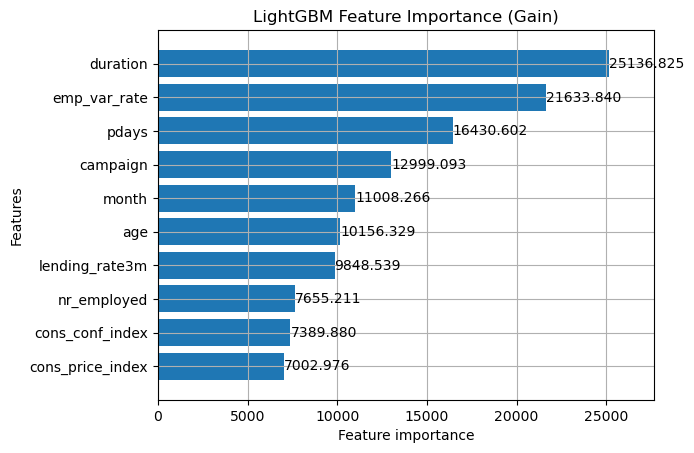

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# 使用 'split', 'gain', 'cover' 作为 importance_type 的不同值
# 'split'：特征被分裂的次数
# 'gain'：特征每次分裂带来的信息增益
# 'cover'：特征分裂时覆盖的样本数

# 可视化 LightGBM 模型的特征重要性
lgb.plot_importance(loaded_model_lgbm, importance_type='gain', max_num_features=10, height=0.8)

# 设置图形标题
plt.title('LightGBM Feature Importance (Gain)')
plt.show()

In [26]:
pip install --upgrade nbconvert notebook

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] 拒绝访问。: 'g:\\anaconda\\scripts\\jupyter-notebook.exe'
Consider using the `--user` option or check the permissions.



   ---------------------------------------- 0.0/13.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.2 MB ? eta -:--:--
   ----- ---------------------------------- 1.8/13.2 MB 16.7 MB/s eta 0:00:01
   ------- -------------------------------- 2.6/13.2 MB 9.4 MB/s eta 0:00:02
   ------- -------------------------------- 2.6/13.2 MB 9.4 MB/s eta 0:00:02
   ------------ --------------------------- 4.2/13.2 MB 5.5 MB/s eta 0:00:02
   --------------- ------------------------ 5.0/13.2 MB 5.5 MB/s eta 0:00:02
   --------------- ------------------------ 5.2/13.2 MB 4.5 MB/s eta 0:00:02
   ----------------- ---------------------- 5.8/13.2 MB 4.1 MB/s eta 0:00:02
   ------------------------ --------------- 8.1/13.2 MB 5.0 MB/s eta 0:00:02
   --------------------------- ------------ 8.9/13.2 MB 5.1 MB/s eta 0:00:01
   --------------------------- ------------ 8.9/13.2 MB 5.1 MB/s eta 0:00:01
   ------------------------------- -------- 10.5/13.2 MB 4.7 MB/s eta 0:00:01
   --------